# Machine Learning Method: XGBoost Method (tree based)

In [271]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from matplotlib import pyplot

Predicting for Coal.SA series only using Coal.SA feature only

In [272]:
df = pd.read_csv("coal-25082020.csv")
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df = df.sort_values(by='Date')
df = df.set_index('Date')
df=df.drop(['Copper','Gold','Silver','IronOre','Coal.Australia', 'CrudeOil','Fuel.Index','NaturalGas','Coal.Producer.Index','CrudeOil.Index','Metal.Index','NonFuel.Index','Commodity.Index','CLI','CCI','BCI'], axis=1)
df.head()

,Coal.SA
Date,
1992-01-01,31.0
1992-01-02,31.0
1992-01-03,31.0
1992-01-04,31.0
1992-01-05,31.0


In [288]:
import warnings
warnings.filterwarnings("ignore")
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)

    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = XGBRegressor(booster='gbtree',objective='reg:squarederror', n_estimators=1000, learning_rate=0.3, alpha=0.1,reg_lambda=0.1,max_depth=25)
    model.fit(trainX, trainy)
    score = model.score(trainX, trainy)   
    #print("Training score: ", score) 
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0], score# walk-forward validation for univariate data

def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat, score = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    
    # estimate prediction error
    error = mean_squared_error(test[:, -1], predictions, squared = False)
    return error, test[:, -1], predictions, score

In [289]:
import warnings
warnings.filterwarnings("ignore")
# load the dataset
series = df
values = series.values
data = series_to_supervised(values, n_in=16)
RMSE, y, yhat, score = walk_forward_validation(data, 55)
print("Training score: ", score) 

>expected=49.1, predicted=47.8
>expected=50.3, predicted=48.3
>expected=52.6, predicted=49.1
>expected=52.4, predicted=50.8
>expected=54.2, predicted=50.4
>expected=58.6, predicted=54.5
>expected=62.4, predicted=61.8
>expected=66.3, predicted=69.5
>expected=68.3, predicted=72.1
>expected=83.8, predicted=66.6
>expected=89.2, predicted=88.5
>expected=80.2, predicted=91.1
>expected=86.5, predicted=90.3
>expected=83.6, predicted=90.9
>expected=79.1, predicted=89.1
>expected=78.9, predicted=80.8
>expected=74.4, predicted=78.1
>expected=79.2, predicted=74.2
>expected=81.7, predicted=78.6
>expected=87.8, predicted=81.0
>expected=92.3, predicted=89.0
>expected=91.4, predicted=91.3
>expected=91.4, predicted=88.0
>expected=95.5, predicted=91.0
>expected=97.5, predicted=98.3
>expected=92.7, predicted=98.2
>expected=89.5, predicted=90.9
>expected=92.3, predicted=81.1
>expected=101.9, predicted=91.4
>expected=103.9, predicted=113.5
>expected=106.0, predicted=112.0
>expected=98.5, predicted=110.3
>e

In [290]:
import sklearn.metrics as sm
print('RMSE: %.3f' % RMSE)
print("R^2 score =", round(sm.r2_score(y, yhat), 2))
# if R^2 is nearly 1, it's the best case.

RMSE: 6.604
R^2 score = 0.83


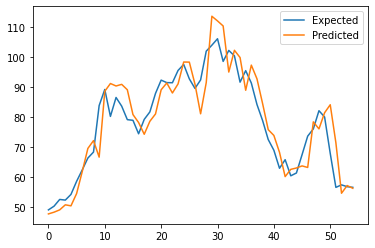

In [291]:
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()